# **Spam Classification and Analysis**

In this project, a spam classifier is built using unsupervised learning (K-Means Clustering) and
multinomial Naïve Bayes. A word cloud is then used to visualize the words from each cluster from the K-Means model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [2]:
# Download NLTK data for stop words and proper nouns
nltk.download('stopwords')
nltk.download('names')
# Download data for the lemmatizer and POS tagger
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/pete/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /home/pete/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pete/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/pete/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/pete/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Global variables
STOP_WORDS = set(stopwords.words('english'))
PROPER_NOUNS = set(nltk.corpus.names.words())

## **Loading the data**

In [4]:
# Load the data and display the first 5 rows
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")
df.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Separate the features from the labels (target)
target = df['label']
features = df.loc[:, 'message']

In [6]:
features.head()  # A one-dimensional Series

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [7]:
target.head()  # A one-dimensional Series

0     ham
1     ham
2    spam
3     ham
4     ham
Name: label, dtype: object

## **Data Preprocessing**

### **Removing unwanted tokens**

Before passing the data to the TF-IDF vectorizer, unwanted tokens are first removed from each row of the dataframe. This involves the following steps (implemented in the `parse_string()` function below):
1. Break down each document into a list of tokens using the `word_tokenize()` function.
2. Filter out punctuations, stop words, and proper nouns from the list.
3. Perform part-of-speech (POS) tagging to determine whether each token is a noun, ajective, verb, or adverb.
4. Lemmatize each token using the `WordNetLemmatizer` based on its POS tag.
5. Combine the tokens into a single string

In [8]:
def get_pos(token):
    """
    Determine whether token is a noun, adjective, verb, or adverb.
    
    Return:
        'n' - noun
        'a' - adjective
        'v' - verb
        'r' - adverb
    """
    tag =  pos_tag([token])[0][1][0].lower()
    if tag not in "navr":
        return 'n'
    else:
        return tag

In [9]:
def parse_string(s):
    """
    Parse a string to remove unwanted tokens.
    
    Punctuations, stop words, and proper nouns are removed and the resulting tokens
    are lemmatized.
    
    Return: a string with the unwanted tokens removed
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(s)
    parsed_tokens = []
    for token in tokens:
        if token.isalpha() and token not in STOP_WORDS and token not in PROPER_NOUNS:
            # Perform part-of-speech tagging
            pos = get_pos(token)
            # Lemmatize the token
            token = lemmatizer.lemmatize(token, pos)
            parsed_tokens.append(token)
    return " ".join(parsed_tokens)

In [10]:
# Apply the 'parse_string' function to each row to remove unwanted tokens
features_parsed = features.apply(parse_string)

In [11]:
# compare a row before and after processing
n = 0
print("-------------------------------")
print(f"Before processing [row {n}]:")
print("-------------------------------")
print(features[n])
print()

print("-------------------------------")
print(f"After processing [row {n}]:")
print("-------------------------------")
print(features_parsed[n])

-------------------------------
Before processing [row 0]:
-------------------------------
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

-------------------------------
After processing [row 0]:
-------------------------------
Go jurong point crazy Available bugis n great world la e buffet Cine get amore wat


### **TF-IDF Vectorization**

In [12]:
# Instantiate the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))

In [13]:
# Get the TF-IDF weights of each term in each document
X = vectorizer.fit_transform(features_parsed)
X.shape

(5572, 6326)

In [14]:
# Convert the TF-IDF weights into a DataFrame.
# The tokens will be the columns and the TF-IDF weights will be the rows
 
feature_names = vectorizer.get_feature_names_out()
X = pd.DataFrame(
        data=X.toarray(),
        columns=feature_names,
)
X.head()

,aa,aah,aaniye,aaooooright,aathi,ab,abdomen,abeg,abel,aberdeen,...,zoom,zouk,zyada,åð,åòharry,åòit,åômorrow,åôrents,ìä,ìï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Train-Test-Split**

Perform a 70-30 train-test-split on the data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=0)

## **Unsupervised Learning: K-Means Clustering**

An unsupervised K-Means clustering model was used to cluster the training data into two categories: `0` and `1`. The output below shows that cluster `0` has 3555 observations while cluster `1` has 345.

In [16]:
# Intantiate the KMeans clustering model
km = KMeans(n_clusters=2, random_state=0, n_init=10)

In [17]:
# Fit the model and obtain the predictions
km_pred = km.fit_predict(X_train)

In [18]:
# Examine the number of observations in each cluster
pd.value_counts(km_pred)

0    3555
1     345
dtype: int64

A DataFrame is created using the model predictions with the index set to that of the training dataset so as to identify which rows belong to which cluster. The rows from each cluster are then separated by using this DataFrame to index the training set.

In [19]:
km_df = pd.DataFrame(data=km_pred, index=X_train.index, columns=["cluster"])
km_df.head()

,cluster
4380,0
3887,0
4755,0
2707,1
4747,0


In [20]:
# Obtain observations from class 0
cluster_0 = X_train.loc[(km_df[km_df['cluster'] == 0]).index]
cluster_0.head()

,aa,aah,aaniye,aaooooright,aathi,ab,abdomen,abeg,abel,aberdeen,...,zoom,zouk,zyada,åð,åòharry,åòit,åômorrow,åôrents,ìä,ìï
4380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Obtain observations from class 1
cluster_1 = X_train.loc[(km_df[km_df['cluster'] == 1]).index]
cluster_1.head()

,aa,aah,aaniye,aaooooright,aathi,ab,abdomen,abeg,abel,aberdeen,...,zoom,zouk,zyada,åð,åòharry,åòit,åômorrow,åôrents,ìä,ìï
2707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Inspect the shapes to verify that the indexing was done correctly
cluster_0.shape, cluster_1.shape

((3555, 6326), (345, 6326))

The **top 25 tokens** from each cluster are as shown below. The tokens are sorted based on their maximum weight across all the documents. By examining the two lists, `cluster 1` most likely consists of spam documents due to occurence of some words frequently seen in spam messages, such as: free, premium, and freephone (a probable mispronunciation of "free phone").

In [23]:
# Get the top 25 tokens from cluster 0
cluster_0.apply(np.max, axis=0).sort_values(ascending=False)[:25]

today           1.0
wish            1.0
ok              1.0
hear            1.0
romantic        1.0
havent          1.0
thursday        1.0
happen          1.0
check           1.0
significance    1.0
cost            1.0
thought         1.0
guy             1.0
early           1.0
continent       1.0
creep           1.0
thanx           1.0
normal          1.0
problem         1.0
perform         1.0
okie            1.0
one             1.0
way             1.0
tough           1.0
wear            1.0
dtype: float64

In [24]:
# Get the top 25 tokens from cluster 1
cluster_1.apply(np.max, axis=0).sort_values(ascending=False)[:25]

call          1.000000
waiting       0.916202
freephone     0.916202
ah            0.882594
tool          0.881645
lunch         0.877230
alter         0.864191
meet          0.850056
dear          0.835679
accomodate    0.833744
tirupur       0.820680
umma          0.792220
free          0.791017
know          0.782602
vivek         0.782502
pa            0.767971
chechi        0.754116
sir           0.746732
min           0.745399
price         0.744573
voicemail     0.741165
sorry         0.739039
machan        0.738359
premium       0.736376
infront       0.730566
dtype: float64

### **Word Cloud Visualization of the Clusters**

The word cloud for `cluster 1` reinforces the suspicion that this cluster consists of spam words. Typical words found in spam emails can be seen from the word cloud, such as: guaranteed, free, urgent, claim, cash, award, etc. This kind of words is not evident from the word cloud of `cluster 0`. 

In [25]:
def show_word_cloud(cluster, name):
    """Construct and display a word cloud using a TF-IDF DataFrame."""
    # Concatenate all tokens into a single string.
    # Repeat each word based on its asssociated weight value.
    # The weights are multiplied by 10 and rounded to obtain the frequencies.
    s = ""
    for i in cluster.index:
        row = cluster.loc[i]
        for word, weight in zip(row.index, row.values):
            s += " ".join([word] * round(weight * 10))
            
    # Draw the word cloud.        
    word_cloud = WordCloud(
            width=3000,
            height=2000,
            random_state=0,
            collocations=False,  # Do not use bigrams
            stopwords=STOP_WORDS,
            ).generate(s)
    plt.imshow(word_cloud)
    plt.axis("off")  # Do no display the axes
    plt.title(name)
    plt.show()

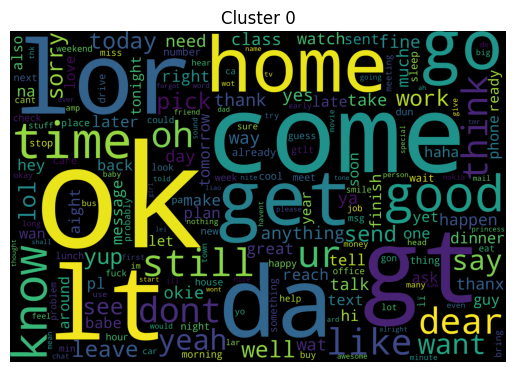

In [26]:
show_word_cloud(cluster_0, "Cluster 0")

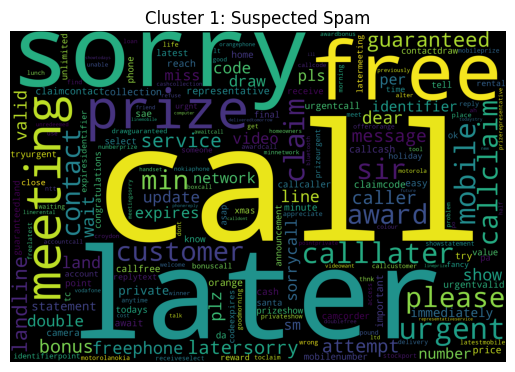

In [27]:
show_word_cloud(cluster_1, "Cluster 1: Suspected Spam")

## **Classification Accuracy of the Unsupervised K-Means Model**

Cluster `1` is assigned the label `spam`, while cluster `0` is assigned `ham`. The classification accuracy is determined by comparing the assigned cluster label with the actual label from the original dataset. The metric is calculated using the sklearn `accuracy_score()` function.

In [28]:
km_df['label'] = km_df['cluster'].replace({1: "spam", 0: "ham"})
km_df.head()

,cluster,label
4380,0,ham
3887,0,ham
4755,0,ham
2707,1,spam
4747,0,ham


In [29]:
# Obtain the predicted and true labels
y_pred = km_df['label']
y_true = df.iloc[km_df.index]['label']

In [30]:
# Get the classification accuracy
accuracy = accuracy_score(y_true, y_pred)

In [31]:
print("Accuracy:", accuracy)

Accuracy: 0.8861538461538462


## **Supervised Learning: Multinomial Naïve Bayes**

A Multinomial Naive Bayes model is fitted with the training set and the accuracy score determined using the testing set.

In [32]:
clf = MultinomialNB()

In [33]:
clf.fit(X_train, y_train)

MultinomialNB()

In [34]:
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9515550239234449
